In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

In [177]:
class Homogenization:

    def __init__(self, g, partition_type="tile", free=False):

        self.g = g
        self.partition_type = partition_type
        self.free = free

        self.translations = np.array([1., 1.])
        self.num_patches = 1

        self.E_data = self.construct_E_data()

    def construct_E_data(self):

        E_data = {}

        if self.partition_type=="tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges:
                    if (v, w) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[v, w][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[w, v][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                    r_ij = np.array([0., 0.])

                E_data[v, w]["r_ij"] = r_ij
    
        elif self.partition_type == "by_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                    i_index = self.V_to_super_V[v]["patch_indices"].copy()
                    j_index = self.V_to_super_V[w]["patch_indices"].copy()
                    ji_ind_dif = j_index - i_index
                    patch_i_coords = self.super_V_coords[self.V_to_super_V[v]["patch_num"]].copy()
                    patch_j_coords = self.super_V_coords[self.V_to_super_V[w]["patch_num"]].copy()

                    if ji_ind_dif[0] == self.num_patches_per_dim - 1:
                        patch_j_coords[0] -= 1
                    elif ji_ind_dif[0] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[0] += 1
                    if ji_ind_dif[1] == self.num_patches_per_dim - 1:
                        patch_j_coords[1] -= 1
                    elif ji_ind_dif[1] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[1] += 1

                    r_ij = patch_j_coords - patch_i_coords

                else:
                    i_num, j_num = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def solve_for_bilinear_coefficients(self, return_all=False):

        if self.free:
            num_conditions = 0
        else:
            num_conditions = 1
            
        C = scipy.sparse.lil_matrix((self.g.num_Vs + num_conditions, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + num_conditions)
        Dy = np.zeros(self.g.num_Vs + num_conditions)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            if self.free:
                if ((v, w) not in self.g.periodic_edges) and ((w, v) not in self.g.periodic_edges):
                    C[v, w] -= 1 / l_vw
                    C[v, v] += 1 / l_vw
            else:
                C[v, w] -= 1 / l_vw
                C[v, v] += 1 / l_vw
                
            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        if not self.free:
            C[-1] = np.ones(self.g.num_Vs)

        C = scipy.sparse.csc_matrix(C)

        alpha_x = sparseqr.solve(C, Dx) #, tolerance = 1e-9)
        alpha_y = sparseqr.solve(C, Dy) #, tolerance = 1e-9)

        print(f"error_x = {np.linalg.norm(C @ alpha_x - Dx)}")
        print(f"error_y = {np.linalg.norm(C @ alpha_y - Dy)}")

        if return_all:
            return C, alpha_x, alpha_y, Dx, Dy
        return alpha_x, alpha_y
    
    def __call__(self):

        alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

        Q = np.zeros((2, 2))
        T = 0.

        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
            alpha_v = np.array([alpha_x[v], alpha_y[v]])
            alpha_w = np.array([alpha_x[w], alpha_y[w]])
            if self.free:
                if ((v, w) not in self.g.periodic_edges) and ((w, v) not in self.g.periodic_edges):
                    fac = (r_ij + alpha_w - alpha_v)
                else:
                    fac = r_ij
            else:
                fac = (r_ij + alpha_w - alpha_v)

            T += l_vw
            Q += fac[:, None] @ fac[None, :] / l_vw

        return Q / T, Q, T

In [2]:
# np.random.seed(0)

# num_Vs_for_tile = 3000

# g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
#                                   num_Vs_for_tile=num_Vs_for_tile,
#                                   num_horizontal_displacements=1, 
#                                   num_vertical_displacements=1,
#                                   autoplot=False)

# g = construct_graph.tiling.Tiling(tile_type="truncated_trihexagonal", 
#                                   num_horizontal_displacements=1, 
#                                   num_vertical_displacements=1,
#                                   figsize=4)

# H = Homogenization(g, partition_type="tile", free=False)
# C0, alpha_x0, alpha_y0, Dx0, Dy0 = H.solve_for_bilinear_coefficients(return_all=True)

In [414]:
class Renormalization:

    def __init__(self, g, partition_type="by_tile", free=False, num_patches_per_dim=None, autoplot=True):

        self.g = g
        self.partition_type = partition_type
        self.free = free

        if self.partition_type == "by_patch":
            self.num_patches_per_dim = num_patches_per_dim
            self.num_patches = self.num_patches_per_dim**2
            self.patch_side_length = 1.0 / self.num_patches_per_dim
        elif self.partition_type == "by_tile":
            self.num_patches = (self.g.num_horizontal_displacements 
                                * self.g.num_vertical_displacements)

        self.super_V_coords, self.patch_coords, self.V_to_super_V, self.translations = self.partition_graph()
        self.E_data = self.construct_E_data()

        if autoplot:
            self.plot_patching(figsize=5)

    def __call__(self, calculation="full"):

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(self.num_patches)]
            T = [0 for _ in range(self.num_patches)]

            for v, w in self.E_data:

                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])
                if self.free:
                    if ((v, w) not in self.g.periodic_edges) and ((w, v) not in self.g.periodic_edges):
                        fac = (r_ij + alpha_w - alpha_v)
                    else:
                        fac = r_ij
                else:
                    fac = (r_ij + alpha_w - alpha_v)

                T[self.V_to_super_V[v]["patch_num"]] += l_vw
                Q[self.V_to_super_V[v]["patch_num"]] += fac[:, None] @ fac[None, :] / l_vw

        return Q, T
    
    def solve_for_bilinear_coefficients(self, return_all=False):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            if self.free:
                if ((v, w) not in self.g.periodic_edges) and ((w, v) not in self.g.periodic_edges):
                    C[v, w] -= 1 / l_vw
                    C[v, v] += 1 / l_vw
            else:
                C[v, w] -= 1 / l_vw
                C[v, v] += 1 / l_vw
                
            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        alpha_x = sparseqr.solve(C, Dx) #, tolerance = 1e-9)
        alpha_y = sparseqr.solve(C, Dy) #, tolerance = 1e-9)

        print(f"error_x = {np.linalg.norm(C @ alpha_x - Dx)}")
        print(f"error_y = {np.linalg.norm(C @ alpha_y - Dy)}")

        if return_all:
            return C, alpha_x, alpha_y, Dx, Dy
        return alpha_x, alpha_y

    def partition_graph(self):
        
        super_V_coords = []
        V_to_super_V = {}
        super_V_to_V = collections.defaultdict(list)
        patch_coords = []

        if self.partition_type == "by_tile":

            tile_num = -1
            for row in range(self.g.num_vertical_displacements):
                for col in range(self.g.num_horizontal_displacements):
                    tile_num += 1
                    v_indices = np.arange(tile_num * self.g.num_Vs_for_tile, (tile_num + 1) * self.g.num_Vs_for_tile)
                    tile = self.g.V_coords[v_indices]
                    super_V_coords.append(np.mean(tile, axis=0))
                    for v_index in v_indices:
                        V_to_super_V[v_index] = {"patch_num": tile_num, 
                                                 "patch_indices": np.array([col, row])}

            # Calculate x, y translations by looking at displacements between tiles
            max_displacement = np.max([self.g.horizontal_displacement, self.g.vertical_displacement])
            horizonal_displacement = (self.g.horizontal_displacement / max_displacement 
                                      / self.g.num_horizontal_displacements)
            vertical_displacement = (self.g.vertical_displacement / max_displacement 
                                     / self.g.num_vertical_displacements)

            translations = np.array([horizonal_displacement, vertical_displacement])

        elif self.partition_type == "by_patch": 

            # Create the patch_coords
            for row in range(self.num_patches_per_dim):
                for col in range(self.num_patches_per_dim):
                    center_x = (col + 0.5) * self.patch_side_length
                    center_y = (row + 0.5) * self.patch_side_length
                    patch_coords.append([center_x, center_y])
            patch_coords = np.array(patch_coords)

            # Assign each vertex to the corresponding patch
            for v_num, (x, y) in enumerate(self.g.V_coords):
                patch_col = np.floor(x / self.patch_side_length).astype(int)
                patch_row = np.floor(y / self.patch_side_length).astype(int)
                patch_num = patch_row * self.num_patches_per_dim + patch_col
                V_to_super_V[v_num] = {"patch_num": patch_num, 
                                       "patch_indices": np.array([patch_col, patch_row])}
                super_V_to_V[patch_num].append(v_num)
                
            # Create super_V_coords
            super_V_coords = []
            for patch_num in range(self.num_patches):
                if self.g.V_coords[super_V_to_V[patch_num]].size == 0:
                    super_V_coords.append(None)
                else:
                    super_V_coords.append(np.mean(self.g.V_coords[super_V_to_V[patch_num]], axis=0))
            # super_V_coords = np.array(super_V_coords)  

            self.super_V_to_V = super_V_to_V      

            translations = np.array([self.patch_side_length, self.patch_side_length])

        return super_V_coords, patch_coords, V_to_super_V, translations
    
    def construct_E_data(self):

        E_data = {}

        if self.partition_type == "by_tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges:
                    a, b = (v % self.g.num_Vs_for_tile), (w % self.g.num_Vs_for_tile) 

                    if (a, b) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                    i, j = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j] - self.super_V_coords[i]

                E_data[v, w]["r_ij"] = r_ij

        elif self.partition_type == "by_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                    i_index = self.V_to_super_V[v]["patch_indices"].copy()
                    j_index = self.V_to_super_V[w]["patch_indices"].copy()
                    ji_ind_dif = j_index - i_index
                    patch_i_coords = self.super_V_coords[self.V_to_super_V[v]["patch_num"]].copy()
                    patch_j_coords = self.super_V_coords[self.V_to_super_V[w]["patch_num"]].copy()

                    if ji_ind_dif[0] == self.num_patches_per_dim - 1:
                        patch_j_coords[0] -= 1
                    elif ji_ind_dif[0] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[0] += 1
                    if ji_ind_dif[1] == self.num_patches_per_dim - 1:
                        patch_j_coords[1] -= 1
                    elif ji_ind_dif[1] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[1] += 1

                    r_ij = patch_j_coords - patch_i_coords

                else:
                    i_num, j_num = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def plot_patching(self, figsize=10, linewidth=2,
                      return_figax=False, plot_V_nums=False):
        
        if self.partition_type == "by_tile":
            raise ValueError("Plotting for partitioning by tile not yet implemented")

        fig, ax = self.g.plot_graph(return_figax=True, figsize=figsize, linewidth=linewidth)
        for center in self.patch_coords:
            bottom_corner = (center[0] - self.patch_side_length / 2, center[1] - self.patch_side_length / 2)
            square = matplotlib.patches.Rectangle(bottom_corner, self.patch_side_length, self.patch_side_length,
                                                  linewidth=2 * linewidth, 
                                                  edgecolor='r', facecolor=(0.8, 0.8, 0.8, 0.1), alpha=1)
            ax.add_patch(square)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        if plot_V_nums:
            for v_num, v_coord in enumerate(self.g.V_coords):
                ax.annotate(str(v_num), v_coord, fontsize=20)

        if return_figax:
            return fig, ax
        plt.show()


|V| = 16


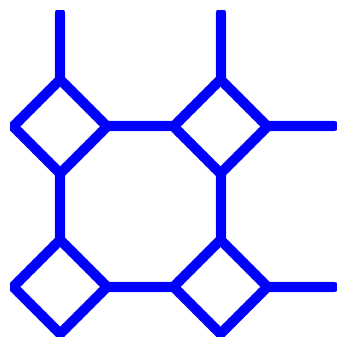

In [5]:
g = construct_graph.tiling.Tiling(tile_type="truncated_square", 
                                  num_horizontal_displacements=2, 
                                  num_vertical_displacements=2,
                                  figsize=4)

In [418]:
class mini:

    def __init__(self, g, free=False):
        self.g = g
        self.translations = np.array([1, 1])
        self.E_data = self.construct_E_data()
        self.free = free

    def __call__(self):

        alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

        Q = np.zeros((2, 2))
        T = 0.

        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
            alpha_v = np.array([alpha_x[v], alpha_y[v]])
            alpha_w = np.array([alpha_x[w], alpha_y[w]])
            if self.free:
                if ((v, w) not in self.g.periodic_edges) and ((w, v) not in self.g.periodic_edges):
                    fac = (r_ij + alpha_w - alpha_v)
                else:
                    fac = r_ij
            else:
                fac = (r_ij + alpha_w - alpha_v)

            T += l_vw
            Q += fac[:, None] @ fac[None, :] / l_vw

        return Q, T

    def solve_for_bilinear_coefficients(self, return_all=False):

        C = scipy.sparse.lil_matrix((self.g.num_Vs, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs)
        Dy = np.zeros(self.g.num_Vs)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            if self.free:
                if ((v, w) not in self.g.periodic_edges) and ((w, v) not in self.g.periodic_edges):
                    C[v, w] -= 1 / l_vw
                    C[v, v] += 1 / l_vw
            else:
                C[v, w] -= 1 / l_vw
                C[v, v] += 1 / l_vw
                
            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C = scipy.sparse.csc_matrix(C)

        alpha_x = sparseqr.solve(C, Dx) #, tolerance = 1e-9)
        alpha_y = sparseqr.solve(C, Dy) #, tolerance = 1e-9)

        print(f"error_x = {np.linalg.norm(C @ alpha_x - Dx)}")
        print(f"error_y = {np.linalg.norm(C @ alpha_y - Dy)}")
        print()

        if return_all:
            return C, alpha_x, alpha_y, Dx, Dy
        return alpha_x, alpha_y

    def construct_E_data(self):
        E_data = {}

        for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
            E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

            if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges:
                a, b = (v % self.g.num_Vs_for_tile), (w % self.g.num_Vs_for_tile) 

                if (a, b) in self.g.connectivity_map: 
                    r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                else: 
                    r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                r_ij = r_ij * self.translations
            else:
                r_ij = np.array([0, 0])

            E_data[v, w]["r_ij"] = r_ij

        return E_data

In [419]:
c = (1 + np.sqrt(2))**2 / 12
# c = (2 + np.sqrt(3)) / 8

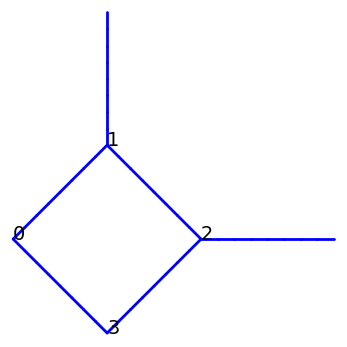

In [453]:
n = 1
g = construct_graph.tiling.Tiling(tile_type="truncated_square", 
                                  num_horizontal_displacements=n, 
                                  num_vertical_displacements=n,
                                  autoplot=False)
M = mini(g, free=False)
fig, ax = g.plot_graph(return_figax=True, figsize=4, linewidth=2)
for en, coords in enumerate(g.V_coords):
    ax.annotate(str(en), coords, fontsize=14)

In [455]:
C, alpha_x, alpha_y, Dx, Dy = M.solve_for_bilinear_coefficients(return_all=True)

error_x = 7.195067539997724e-16
error_y = 1.2803716525534355e-15



In [456]:
alpha_x

array([-2.50000000e-01, -4.22417048e-17,  2.50000000e-01,  0.00000000e+00])

In [213]:
ell = 1 / (2 * (1 + np.sqrt(2)))

In [454]:
Q, T = M()
print(Q)
print(T)
print()
print(Q / T)
print()
print((Q / T)[0, 0] / c)
print((Q / T)[1, 1] / c)
print(np.mean(((Q / T)[0, 0] / c, (Q / T)[1, 1] / c)) / g.num_Vs)

error_x = 7.195067539997724e-16
error_y = 1.2803716525534355e-15

[[ 2.41421356e+00 -5.55111512e-17]
 [-5.55111512e-17  2.41421356e+00]]
4.97056274847714

[[ 4.85702260e-01 -1.11679812e-17]
 [-1.11679812e-17  4.85702260e-01]]

[[-3.96028648e+02+5.82419784e+01j -3.96028648e+02+5.82419784e+01j]
 [-3.75470527e+02-1.38754103e+02j -3.03117168e+02-1.12016118e+02j]
 [-2.62984126e+02-3.01778341e+02j -1.91694851e+02-2.19972798e+02j]
 [-8.61100398e+01-3.90916716e+02j -6.20286327e+01-2.81593522e+02j]
 [ 1.11846788e+02-3.84345045e+02j  8.69503587e+01-2.98792126e+02j]
 [ 2.82419621e+02-2.83672303e+02j  2.62748928e+02-2.63914360e+02j]
 [ 3.83846281e+02-1.13546688e+02j  4.97307353e+02-1.47109938e+02j]
 [ 3.91293985e+02+8.43791171e+01j  9.70733066e+02+2.09330075e+02j]
 [ 3.02939274e+02+2.61645971e+02j  1.55511608e+16-8.32768057e+15j]
 [ 1.40414463e+02+3.74852766e+02j -3.48344130e+02-9.29945231e+02j]
 [-5.64887048e+01+3.96282531e+02j  7.31861936e+01-5.13419631e+02j]
 [-2.39561468e+02+3.20688511e+02j  2